# HW4
1.  제 6  장의 dogs/cats  를 제 8  장에서 사용한 VGG16  모형과 잔차연결을 적용하여 제 6  장의 결과와 비교할 것

## U-Net

In [24]:
# 관련 이미지가 들어있는 디렉토리 지정
train_dir = '/content/drive/MyDrive/Colab Notebooks/DL/[STAT433] 딥러닝을 위한 통계적모델링/data/dogs and cats_small/train'
validation_dir = '/content/drive/MyDrive/Colab Notebooks/DL/[STAT433] 딥러닝을 위한 통계적모델링/data/dogs and cats_small/validation'
test_dir = '/content/drive/MyDrive/Colab Notebooks/DL/[STAT433] 딥러닝을 위한 통계적모델링/data/dogs and cats_small/test'

from tensorflow.keras.preprocessing.image import ImageDataGenerator 
train_datagen=ImageDataGenerator(rescale=1./255,rotation_range=40, width_shift_range=0.2, 
                               height_shift_range=0.2, shear_range=0.2, zoom_range=0.2,
                                horizontal_flip=True, fill_mode='nearest')    # augmentation > error 추가small/validation'
                                                                                         
test_datagen=ImageDataGenerator(rescale=1./255)   ## 뒤에서는 이 부분에 augmentation을 한다!

# .flow_from_directory를 이용 
train_generator=train_datagen.flow_from_directory(directory=train_dir,target_size=(224,224),   # input size 224 변경
                                                  batch_size=20,class_mode='binary')
validation_generator=test_datagen.flow_from_directory(directory=validation_dir,target_size=(224,224),
                                                      batch_size=20,class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1010 images belonging to 2 classes.


In [25]:
# Pretrained VGG
from tensorflow.keras.applications import VGG16  # 파라미터 freeze
base_vgg16=VGG16(weights='imagenet',include_top=False, input_shape=(224,224,3)) 
base_vgg16.trainable = False  # training 안함
base_vgg16.summary()  # 이미 training 되어있음

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [59]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D,UpSampling2D, Dropout, concatenate, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model

# vgg의 layer를 모두 변수에 저장하기
conv1 = Model(inputs=base_vgg16.input,outputs=base_vgg16.get_layer('block1_conv2').output).output  # vgg의 output을 따로 받아서 conv1에 저장함
conv2 = Model(inputs=base_vgg16.input,outputs=base_vgg16.get_layer('block2_conv2').output).output
conv3 = Model(inputs=base_vgg16.input,outputs=base_vgg16.get_layer('block3_conv3').output).output
conv4 = Model(inputs=base_vgg16.input,outputs=base_vgg16.get_layer('block4_conv3').output).output
drop4 = Dropout(0.5)(conv4)
conv5 = Model(inputs=base_vgg16.input,outputs=base_vgg16.get_layer('block5_conv3').output).output
drop5 = Dropout(0.5)(conv5)

In [60]:
print(drop4)
print(drop5)   # 최종적으로 (6,6,512) 텐서 출력중임

KerasTensor(type_spec=TensorSpec(shape=(None, 28, 28, 512), dtype=tf.float32, name=None), name='dropout_10/Identity:0', description="created by layer 'dropout_10'")
KerasTensor(type_spec=TensorSpec(shape=(None, 14, 14, 512), dtype=tf.float32, name=None), name='dropout_11/Identity:0', description="created by layer 'dropout_11'")


In [61]:
## functional API
up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer='he_normal')(UpSampling2D(size =(2,2))(drop5))
merge6 = concatenate([drop4,up6], axis = -1)  # 마지막 drop5를 upsampling 시킴 

conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer='he_normal')(merge6)
conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer='he_normal')(conv6)
conv6 = BatchNormalization()(conv6)

up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer='he_normal')(UpSampling2D(size =(2,2))(conv6))
merge7 = concatenate([conv3,up7], axis = -1)
conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer='he_normal')(merge7)
conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer='he_normal')(conv7)
conv7 = BatchNormalization()(conv7)
up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer='he_normal')(UpSampling2D(size =(2,2))(conv7))
merge8 = concatenate([conv2,up8],axis = -1)
conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer='he_normal')(merge8)
conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer='he_normal')(conv8)
conv8 = BatchNormalization()(conv8)

up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer='he_normal')(UpSampling2D(size =(2,2))(conv8))
merge9 = concatenate([conv1,up9], axis = -1)
conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer='he_normal')(merge9)
conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer='he_normal')(conv9)
conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer='he_normal')(conv9)
conv9 = BatchNormalization()(conv9)

conv10 = Conv2D(1, 1, activation = 'relu')(conv9)    # 픽셀별 객체 구분

In [62]:
# flatten 더하고 dense추가 ! (functional API)
import tensorflow as tf
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
f = Flatten()(conv10)
f = Dense(64, activation='relu',kernel_initializer='he_normal' )(f)
f = Dropout(0.5)(f)
out = Dense(1, activation='sigmoid',  kernel_regularizer=tf.keras.regularizers.L1(0.01))(f)

In [63]:
model = Model(base_vgg16.input, out)
model.summary()

Model: "model_22"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 224, 224, 64) 1792        input_5[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 224, 224, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 112, 112, 64) 0           block1_conv2[0][0]               
___________________________________________________________________________________________

In [64]:
for layer in model.layers[:18]:
  layer.trainable = False

In [65]:
model.compile(optimizer=Adam(1e-3, decay = 1e-6), 
                   loss='binary_crossentropy', metrics = ['accuracy'])

In [66]:
history = model.fit_generator(train_generator,
                      steps_per_epoch=100,   # 100개의 배치를 사용
                      epochs=30, 
                      validation_data=validation_generator,
                      validation_steps=50)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
100/100 [==============================] - 54s 523ms/step - loss: 1.6820 - accuracy: 0.5142 - val_loss: 0.7629 - val_accuracy: 0.4930
Epoch 2/30
100/100 [==============================] - 52s 519ms/step - loss: 0.7493 - accuracy: 0.6194 - val_loss: 0.4978 - val_accuracy: 0.8210
Epoch 3/30
100/100 [==============================] - 52s 519ms/step - loss: 0.6338 - accuracy: 0.7592 - val_loss: 0.3657 - val_accuracy: 0.8800
Epoch 4/30
100/100 [==============================] - 52s 519ms/step - loss: 0.4819 - accuracy: 0.8318 - val_loss: 0.4480 - val_accuracy: 0.8660
Epoch 5/30
100/100 [==============================] - 52s 519ms/step - loss: 0.4847 - accuracy: 0.8210 - val_loss: 0.4676 - val_accuracy: 0.7920
Epoch 6/30
100/100 [==============================] - 52s 519ms/step - loss: 0.4153 - accuracy: 0.8591 - val_loss: 1.3273 - val_accuracy: 0.5050
Epoch 7/30
100/100 [==============================] - 52s 519ms/step - loss: 0.4290 - accuracy: 0.8543 - val_loss: 0.3149 - val_ac

In [67]:
test_datagen=ImageDataGenerator(rescale=1./255)
test_generator=test_datagen.flow_from_directory(test_dir,target_size=(224,224),
                                              batch_size=20, class_mode='binary')

Found 1000 images belonging to 2 classes.


In [68]:
loss, acc=model.evaluate(test_generator,steps=50) 

50/50 [==============================] - 9s 175ms/step - loss: 0.4413 - accuracy: 0.8640


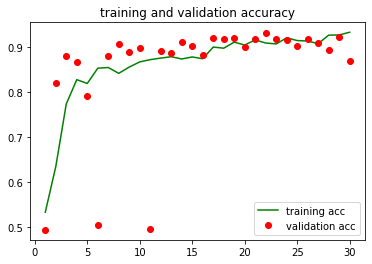

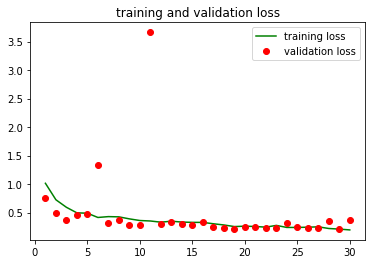

In [69]:
import matplotlib.pyplot as plt
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']
epochs=range(1,len(acc)+1)

plt.plot(epochs,acc,'g',label='training acc')
plt.plot(epochs,val_acc,'ro',label='validation acc')
plt.title('training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs,loss,'g',label='training loss')
plt.plot(epochs,val_loss,'ro',label='validation loss')
plt.title('training and validation loss')
plt.legend()
plt.show()

- U-net은 픽셀기반으로 이미지를 분할한다. 따라서 각 픽셀마다 객체를 분류하는 Segmentation에 특화된 모델이다. 
- 따라서 Input은 픽셀별 rgb 데이터이고, output은 각 픽셀별 객체 구분정보이다(class) 하지만 이 개/고양이 분류에서는 이 픽셀별 객체 구분정보가 단순 flatten되었고, 이 flatten 된 것을 dense로 분류하였으므로 무언가 맞지 않는다. 

- U-net은 수축경로에서 채널 범위(참조 범위)를 넓혀가며 contextual 정보를 추출하는 역할을 하고, 전환구간에서 dropout을 통해 노이즈에 견고하게 만든다. 또한 확장경로에서는 Unsampling 과정을 반복하며 이전 layer의 feature map과 concat한다. 

- 마지막 1*1 conv layer는 각 픽셀이 어떤 class에 해당하는지에 대한 정보를 나타내는 3차원 벡터가 생성된다. 

> 결론적으로 원래 모델이 훨씬 좋다. U-net은 픽셀단위 연산을 진행하기 떄문이다. 

### 원래 모델 

In [54]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
model_aug=Sequential()

from tensorflow.keras.applications import VGG16  # 파라미터 freeze
vgg_base=VGG16(weights='imagenet',include_top=False, input_shape=(224,224,3)) 

######### 우선 vgg 구조를 모델에 추가하기 ######
model_aug.add(vgg_base)  # 여기에 아예 집어넣음 >> 근데 여기 파라미터는 freez 시켜야함.(아니면 2000개의 파라미터를 가지고 1400만개의 파라미터를 추정하는 꼴이 됨) 그럼 위 과정과 완전히 같아진다. 
model_aug.add(Flatten())
model_aug.add(Dense(64,activation='relu', kernel_initializer='he_normal'))
model_aug.add(Dropout(0.5))
model_aug.add(Dense(1,activation='sigmoid', kernel_regularizer=tf.keras.regularizers.L1(0.01)))  # 드랍아웃을 안했기때문에 위 결과보다 나쁠수밖에 없음. 
model_aug.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_3 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 64)                1605696   
_________________________________________________________________
dropout_9 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 65        
Total params: 16,320,449
Trainable params: 16,320,449
Non-trainable params: 0
_________________________________________________________________


In [56]:
from tensorflow.keras import optimizers
model_aug.compile(optimizer=optimizers.RMSprop(lr=2e-5),loss='binary_crossentropy',metrics=['acc'])
model_aug_result=model_aug.fit_generator(train_generator,
                                         steps_per_epoch=100,   # 100개의 배치를 사용
                                         epochs=10, 
                                         validation_data=validation_generator,
                                         validation_steps=50)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
100/100 [==============================] - 32s 308ms/step - loss: 0.7961 - acc: 0.5828 - val_loss: 0.3257 - val_acc: 0.9270
Epoch 2/10
100/100 [==============================] - 30s 302ms/step - loss: 0.4662 - acc: 0.8330 - val_loss: 0.2397 - val_acc: 0.9420
Epoch 3/10
100/100 [==============================] - 30s 303ms/step - loss: 0.3460 - acc: 0.8984 - val_loss: 0.3012 - val_acc: 0.9220
Epoch 4/10
100/100 [==============================] - 31s 308ms/step - loss: 0.2682 - acc: 0.9332 - val_loss: 0.1863 - val_acc: 0.9630
Epoch 5/10
100/100 [==============================] - 30s 303ms/step - loss: 0.2300 - acc: 0.9461 - val_loss: 0.1607 - val_acc: 0.9740
Epoch 6/10
100/100 [==============================] - 31s 307ms/step - loss: 0.2084 - acc: 0.9618 - val_loss: 0.3273 - val_acc: 0.8980
Epoch 7/10
100/100 [==============================] - 31s 305ms/step - loss: 0.2159 - acc: 0.9543 - val_loss: 0.1542 - val_acc: 0.9770
Epoch 8/10
100/100 [==============================] - 3

In [57]:
loss, acc=model_aug.evaluate(test_generator,steps=50) 

50/50 [==============================] - 4s 81ms/step - loss: 0.1593 - acc: 0.9760


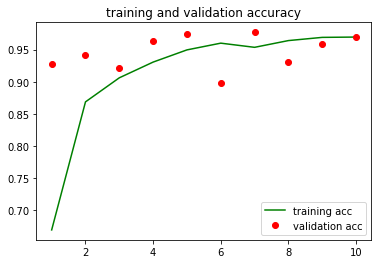

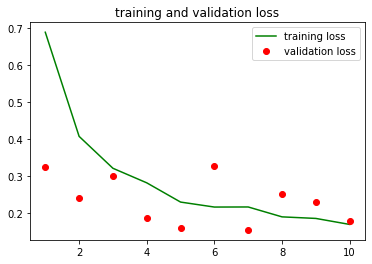

In [58]:
import matplotlib.pyplot as plt
acc=model_aug_result.history['acc']
val_acc=model_aug_result.history['val_acc']
loss=model_aug_result.history['loss']
val_loss=model_aug_result.history['val_loss']
epochs=range(1,len(acc)+1)

plt.plot(epochs,acc,'g',label='training acc')
plt.plot(epochs,val_acc,'ro',label='validation acc')
plt.title('training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs,loss,'g',label='training loss')
plt.plot(epochs,val_loss,'ro',label='validation loss')
plt.title('training and validation loss')
plt.legend()
plt.show()